# TD3 Attempt

## Set-up

### Dependencies and imports

In [1]:
# !pip install swig
# !pip install --upgrade rldurham

In [2]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

### Prepare the environment and wrap it to capture statistics, logs, and videos

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


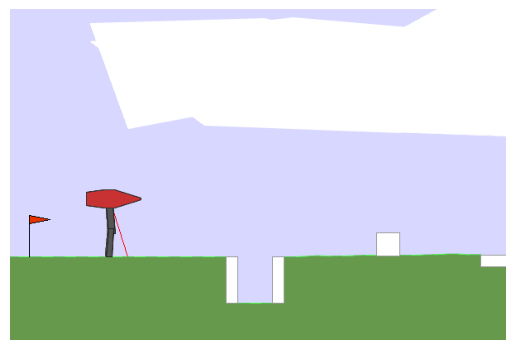

In [3]:
# env = rld.make("rldurham/Walker", render_mode="rgb_array")
env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="nkfn77-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

## Agent

### Agent class

In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta,Normal
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, net_width, maxaction):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, action_dim)

		self.maxaction = maxaction

	def forward(self, state):
		a = torch.tanh(self.l1(state))
		a = torch.tanh(self.l2(a))
		a = torch.tanh(self.l3(a)) * self.maxaction
		return a


class Q_Critic(nn.Module):
	def __init__(self, state_dim, action_dim, net_width):
		super(Q_Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, net_width)
		self.l5 = nn.Linear(net_width, net_width)
		self.l6 = nn.Linear(net_width, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1



class TD3(object):
	def __init__(
		self,
		env_with_Dead,
		state_dim,
		action_dim,
		max_action,
		gamma=0.99,
		net_width=128,
		a_lr=1e-4,
		c_lr=1e-4,
		Q_batchsize = 256,
		per = True
	):

		self.actor = Actor(state_dim, action_dim, net_width, max_action).to(device)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=a_lr)
		self.actor_target = copy.deepcopy(self.actor)

		self.q_critic = Q_Critic(state_dim, action_dim, net_width).to(device)
		self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=c_lr)
		self.q_critic_target = copy.deepcopy(self.q_critic)

		self.env_with_Dead = env_with_Dead
		self.action_dim = action_dim
		self.max_action = max_action
		self.gamma = gamma
		self.policy_noise = 0.2*max_action
		self.noise_clip = 0.5*max_action
		self.tau = 0.005
		self.Q_batchsize = Q_batchsize
		self.delay_counter = -1
		self.delay_freq = 1 # Changed from 1
  
		self.per = per

	def select_action(self, state):#only used when interact with the env
		with torch.no_grad():
			state = torch.FloatTensor(state.reshape(1, -1)).to(device)
			a = self.actor(state)
		return a.cpu().numpy().flatten()

	# def train(self,replay_buffer):
	# 	self.delay_counter += 1
	# 	s, a, r, s_prime, dead_mask = replay_buffer.sample(self.Q_batchsize)
	# 	with torch.no_grad():
	# 		noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
	# 		smoothed_target_a = (
	# 				self.actor_target(s_prime) + noise  # Noisy on target action
	# 		).clamp(-self.max_action, self.max_action)

	# 	# Compute the target Q value
	# 	target_Q1, target_Q2 = self.q_critic_target(s_prime, smoothed_target_a)
	# 	target_Q = torch.min(target_Q1, target_Q2)
	# 	'''DEAD OR NOT'''
	# 	if self.env_with_Dead:
	# 		target_Q = r + (1 - dead_mask) * self.gamma * target_Q  # env with dead
	# 	else:
	# 		target_Q = r + self.gamma * target_Q  # env without dead


	# 	# Get current Q estimates
	# 	current_Q1, current_Q2 = self.q_critic(s, a)

	# 	# Compute critic loss
	# 	q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

	# 	# Optimize the q_critic
	# 	self.q_critic_optimizer.zero_grad()
	# 	q_loss.backward()
	# 	self.q_critic_optimizer.step()

	# 	if self.delay_counter == self.delay_freq:
	# 		# Update Actor
	# 		a_loss = -self.q_critic.Q1(s,self.actor(s)).mean()
	# 		self.actor_optimizer.zero_grad()
	# 		a_loss.backward()
	# 		self.actor_optimizer.step()

	# 		# Update the frozen target models
	# 		for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
	# 			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

	# 		for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
	# 			target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

	# 		self.delay_counter = -1

	def train(self, replay_buffer):
		self.delay_counter += 1
		
		# Sample with priorities and get importance-sampling weights
		s, a, r, s_prime, dead_mask, weights, indices = replay_buffer.sample(self.Q_batchsize)
		
		with torch.no_grad():
			# Add noise to actions for smoothing
			noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
			smoothed_target_a = (
				self.actor_target(s_prime) + noise
			).clamp(-self.max_action, self.max_action)
			
			# Compute the target Q value
			target_Q1, target_Q2 = self.q_critic_target(s_prime, smoothed_target_a)
			target_Q = torch.min(target_Q1, target_Q2)
			
			# Apply discount factor based on terminal state
			if self.env_with_Dead:
				target_Q = r + (1 - dead_mask) * self.gamma * target_Q  # env with dead
			else:
				target_Q = r + self.gamma * target_Q  # env without dead
				
		# Get current Q estimates
		current_Q1, current_Q2 = self.q_critic(s, a)
		
		# Compute TD errors for updating priorities
		td_error1 = torch.abs(current_Q1 - target_Q).detach()
		td_error2 = torch.abs(current_Q2 - target_Q).detach()
		td_errors = torch.max(td_error1, td_error2).squeeze().cpu().numpy()
		
		# Update priorities in the replay buffer
		replay_buffer.update_priorities(indices, td_errors)
		
		# Compute critic loss with importance-sampling weights
		q1_loss = (weights * F.mse_loss(current_Q1, target_Q, reduction='none')).mean()
		q2_loss = (weights * F.mse_loss(current_Q2, target_Q, reduction='none')).mean()
		q_loss = q1_loss + q2_loss
		
		# Optimize the q_critic
		self.q_critic_optimizer.zero_grad()
		q_loss.backward()
		torch.nn.utils.clip_grad_norm_(self.q_critic.parameters(), 1.0)  # Add gradient clipping
		self.q_critic_optimizer.step()
		
		# Delayed policy updates
		if self.delay_counter == self.delay_freq:
			# Update Actor - no need for importance sampling weights here
			a_loss = -self.q_critic.Q1(s, self.actor(s)).mean()
			self.actor_optimizer.zero_grad()
			a_loss.backward()
			torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)  # Add gradient clipping
			self.actor_optimizer.step()
			
			# Update the frozen target models
			for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
				
			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
				
			self.delay_counter = -1

	def save(self,episode):
		torch.save(self.actor.state_dict(), "actor/ppo_actor{}.pth".format(episode))
		torch.save(self.q_critic.state_dict(), "critic/ppo_q_critic{}.pth".format(episode))


	def load(self,episode):
		self.actor.load_state_dict(torch.load("actor/ppo_actor{}.pth".format(episode)))
		self.q_critic.load_state_dict(torch.load("critic/ppo_q_critic{}.pth".format(episode)))

### Replay Buffer

In [5]:
import numpy as np
import torch


class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.reward = np.zeros((max_size, 1))
		self.next_state = np.zeros((max_size, state_dim))
		self.dead = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, reward, next_state, dead):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.reward[self.ptr] = reward
		self.next_state[self.ptr] = next_state
		self.dead[self.ptr] = dead #0,0,0，...，1

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.dead[ind]).to(self.device)
		)

### Replay buffer - prioritised

In [ ]:
import numpy as np
import torch
import random
from segment_tree import SumSegmentTree, MinSegmentTree

class PrioritizedReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e5), alpha=0.6, beta=0.4, beta_increment=1e-4):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        
        # Storage for experiences
        self.state = np.zeros((max_size, state_dim), dtype=np.float32)
        self.action = np.zeros((max_size, action_dim), dtype=np.float32)
        self.reward = np.zeros((max_size, 1), dtype=np.float32)
        self.next_state = np.zeros((max_size, state_dim), dtype=np.float32)
        self.dead = np.zeros((max_size, 1), dtype=np.float32)
        
        # Parameters for prioritization
        self.alpha = alpha  # how much prioritization to use (0 = uniform, 1 = full prioritization)
        self.beta = beta    # importance-sampling correction factor
        self.beta_increment = beta_increment  # increment beta over time
        self.max_priority = 1.0
        
        # Create segment trees for efficient sum and min operations
        tree_capacity = 1
        while tree_capacity < max_size:
            tree_capacity *= 2
            
        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, reward, next_state, dead):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.reward[self.ptr] = reward
        self.next_state[self.ptr] = next_state
        self.dead[self.ptr] = dead
        
        # New experiences get maximum priority
        priority = self.max_priority ** self.alpha
        self.sum_tree[self.ptr] = priority
        self.min_tree[self.ptr] = priority
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        # Increase beta over time for more accurate corrections
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        indices = []
        weights = np.zeros(batch_size, dtype=np.float32)
        
        # Get the minimum priority (with non-zero probability)
        min_priority = self.min_tree.min() / self.sum_tree.sum()
        
        # Sample indices based on priorities
        for i in range(batch_size):
            # Sample uniformly from [0, sum of priorities]
            mass = random.random() * self.sum_tree.sum()
            
            # Get index from the sum tree
            idx = self.sum_tree.find_prefixsum_idx(mass)
            indices.append(idx)
            
            # Calculate importance-sampling weights
            p_sample = self.sum_tree[idx] / self.sum_tree.sum()
            weight = (p_sample * self.size) ** (-self.beta)
            weights[i] = weight
        
        # Normalize weights to stabilize training
        weights = weights / np.max(weights)
        
        states = torch.FloatTensor(self.state[indices]).to(self.device)
        actions = torch.FloatTensor(self.action[indices]).to(self.device)
        rewards = torch.FloatTensor(self.reward[indices]).to(self.device)
        next_states = torch.FloatTensor(self.next_state[indices]).to(self.device)
        deads = torch.FloatTensor(self.dead[indices]).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)
        indices = torch.LongTensor(indices).to(self.device)
        
        return states, actions, rewards, next_states, deads, weights, indices
    
    def update_priorities(self, indices, priorities):
        """Update priorities of sampled transitions"""
        for idx, priority in zip(indices, priorities):
            idx = idx.item()  # Convert from tensor to int
            
            # Clip priority for stability
            priority = max(1e-6, priority)
            
            # Update max priority for new samples
            self.max_priority = max(self.max_priority, priority)
            
            # Update both trees
            priority_alpha = priority ** self.alpha
            self.sum_tree[idx] = priority_alpha
            self.min_tree[idx] = priority_alpha

# Segment Tree implementation for efficient sum and min operations
class SegmentTree:
    def __init__(self, capacity, operation, neutral_element):
        self.capacity = capacity
        self.operation = operation
        self.neutral_element = neutral_element
        self.tree = [neutral_element for _ in range(2 * capacity)]
    
    def _operate_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        elif start >= mid + 1:
            return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
        else:
            return self.operation(
                self._operate_helper(start, mid, 2 * node, node_start, mid),
                self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
            )
    
    def operate(self, start=0, end=None):
        if end is None:
            end = self.capacity - 1
        return self._operate_helper(start, end, 1, 0, self.capacity - 1)
    
    def __setitem__(self, idx, val):
        idx += self.capacity
        self.tree[idx] = val
        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2
    
    def __getitem__(self, idx):
        return self.tree[idx + self.capacity]

class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=lambda a, b: a + b,
            neutral_element=0.0
        )
    
    def sum(self, start=0, end=None):
        return self.operate(start, end)
    
    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the tree such that
        sum(tree[0:i]) <= prefixsum"""
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self.capacity:  # While not a leaf
            if self.tree[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self.tree[2 * idx]
                idx = 2 * idx + 1
        return idx - self.capacity

class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )
    
    def min(self, start=0, end=None):
        return self.operate(start, end)


# Code showing how to modify the TD3 train method to use prioritized replay
def train_with_per(self, replay_buffer):
    self.delay_counter += 1
    
    # Sample with priorities and get importance-sampling weights
    s, a, r, s_prime, dead_mask, weights, indices = replay_buffer.sample(self.Q_batchsize)
    
    with torch.no_grad():
        noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
        smoothed_target_a = (
            self.actor_target(s_prime) + noise
        ).clamp(-self.max_action, self.max_action)
        
        # Compute the target Q value
        target_Q1, target_Q2 = self.q_critic_target(s_prime, smoothed_target_a)
        target_Q = torch.min(target_Q1, target_Q2)
        
        if self.env_with_Dead:
            target_Q = r + (1 - dead_mask) * self.gamma * target_Q
        else:
            target_Q = r + self.gamma * target_Q
            
    # Get current Q estimates
    current_Q1, current_Q2 = self.q_critic(s, a)
    
    # Compute TD errors for updating priorities
    td_error1 = torch.abs(current_Q1 - target_Q).detach()
    td_error2 = torch.abs(current_Q2 - target_Q).detach()
    td_errors = torch.max(td_error1, td_error2).squeeze().cpu().numpy()
    
    # Update priorities in the replay buffer
    replay_buffer.update_priorities(indices, td_errors)
    
    # Compute critic loss with importance-sampling weights
    q1_loss = (weights * F.mse_loss(current_Q1, target_Q, reduction='none')).mean()
    q2_loss = (weights * F.mse_loss(current_Q2, target_Q, reduction='none')).mean()
    q_loss = q1_loss + q2_loss
    
    # Optimize the q_critic
    self.q_critic_optimizer.zero_grad()
    q_loss.backward()
    self.q_critic_optimizer.step()
    
    if self.delay_counter == self.delay_freq:
        # Update Actor - no need for importance sampling weights here
        a_loss = -self.q_critic.Q1(s, self.actor(s)).mean()
        self.actor_optimizer.zero_grad()
        a_loss.backward()
        self.actor_optimizer.step()
        
        # Update the frozen target models
        for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
        self.delay_counter = -1

## Training

### Training loop

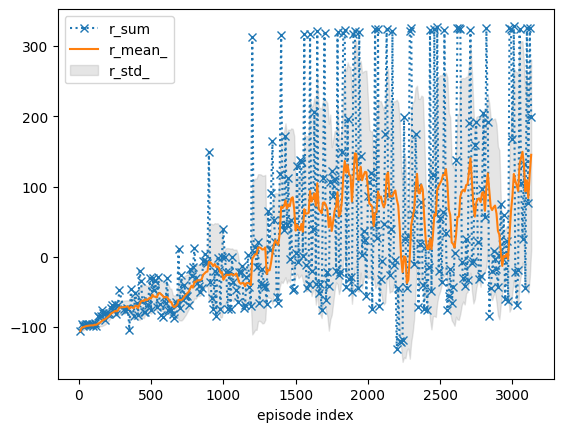

seed: 42 episode: 3139 score: 324.05665808407684 step: 900 smoothed score: 137.91115250604562


In [ ]:
import numpy as np
import torch
import rldurham as rld
import os

# Ensure folder is created for model save points
os.makedirs("actor", exist_ok=True)
os.makedirs("critic", exist_ok=True)

# Training on CPU recommended
rld.check_device()

# Environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# Render start image
rld.render(env)

# Check if the environment has continuous action space
env_with_Dead = True  # Whether the Env has dead state
state_dim = obs_dim
action_dim = act_dim
max_action = 1.0  # Walker environment typically has actions scaled to [-1, 1]

print(' state_dim:', state_dim, ' action_dim:', action_dim, 
        ' max_a:', max_action, ' min_a:', -max_action)

# Training parameters
max_episodes = 8000
max_timesteps = 2000
save_interval = 100
expl_noise = 0.25

# Set random seeds (already set by seed_everything but keeping for clarity)
torch.manual_seed(seed)
np.random.seed(seed)

# Create the agent
kwargs = {
    "env_with_Dead": env_with_Dead,
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "gamma": 0.99,
    "net_width": 256,
    "a_lr": 1e-4,
    "c_lr": 1e-4,
    "Q_batchsize": 256,
}

agent = TD3(**kwargs)

# Create replay buffer
# replay_buffer = ReplayBuffer(state_dim, action_dim, max_size=int(9e4)) # changed from 1e6 to see if memory issues are better
replay_buffer = PrioritizedReplayBuffer(state_dim, action_dim, max_size=int(9e4)) # changed from 1e6 to see if memory issues are better

# Track statistics for plotting
tracker = rld.InfoTracker()
all_ep_r = []

# Training procedure
for episode in range(max_episodes):
    # Recording statistics and video can be switched on and off (video recording is slow!)
    env.info = episode % 10 == 0  # track every x episodes
    env.video = episode % 10 == 0  # record videos every x episodes
    
    # Reset for new episode
    observation, info = env.reset()
    episode_reward = 0
    steps = 0
    
    # Decay exploration noise
    expl_noise *= 0.999
    
    # Episode loop
    for t in range(max_timesteps):
        steps += 1
        
        # Select action with exploration noise
        action = (
            agent.select_action(observation) + 
            np.random.normal(0, max_action * expl_noise, size=action_dim)
        ).clip(-max_action, max_action)
        
        # Take action in the environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Accumulate episode reward
        episode_reward += reward
        
        # Check whether done
        done = terminated or truncated
        
        # Special reward handling for Walker environments
        if reward <= -100 and env_with_Dead:
            reward = -1
            replay_buffer.add(observation, action, reward, next_observation, True)
        else:
            replay_buffer.add(observation, action, reward, next_observation, done)
        
        # Update current observation
        observation = next_observation
        
        # Train the agent if buffer has enough samples
        if replay_buffer.size > 2000:
            agent.train(replay_buffer)
        
        # Stop episode if done
        if done:
            break
    
    # Save model at specified intervals
    if (episode + 1) % save_interval == 0:
        agent.save(episode + 1)
    
    # Record and log statistics
    if episode == 0:
        all_ep_r.append(episode_reward)
    else:
        all_ep_r.append(all_ep_r[-1] * 0.9 + episode_reward * 0.1)
    
    # Track and plot statistics
    tracker.track(info)
    
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
        print('seed:', seed, 'episode:', episode, 'score:', episode_reward, 
                'step:', steps, 'smoothed score:', all_ep_r[-1])

# Don't forget to close environment (e.g. triggers last video save)
env.close()

# Write log file (for coursework)
env.write_log(folder="logs", file="nkfn77-agent-log.txt")  # replace with your username



### Demo

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [ ]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()